# Status

Currently interactive widgets and visualizations tools for notebooks mostly only work with Python.  When porting matlab/octave code to jupyter notebooks, it often makes sense to write the UI and visualization using Python and use oct2py to call the existing matlab/octave code.

# Octave <--> Python Integration with Oct2Py

Before we can use Octave, we need to load Octave into the environment.
The currently installed versions can be found by typing "use" in a hub console,
or we can do it from a cell.

In [1]:
! /etc/environ bash use 2>&1 >/dev/null | grep 'octave'

octave-3.6.4:   OCTAVE is a numerical computing environment and programming language.  It allows for easy matrix manipulation. It is an alternative to Matlab
octave-4.0.0:   OCTAVE is a numerical computing environment and programming language.  It allows for easy matrix manipulation. It is an alternative to Matlab
octave-4.2.0:   OCTAVE is a numerical computing environment and programming language.  It allows for easy matrix manipulation. It is an alternative to Matlab


In [2]:
import hublib.use
%use octave-4.2.0

Now that octave is installed on our PATH for the notebook, we load the Octave "line magics".

In [3]:
import oct2py
%load_ext oct2py.ipython

Lets test it out by asking Octave for the value of pi.

In [4]:
%octave pi

ans =  3.1416

3.1415926535897931

Note that we see Octave evaluate pi and display its value and we also see the value returned to the output cell.
We can end the Octave code with a semicolon if we don't want it displayed.  We can also assign the returned value to a Python variable.

In [5]:
pi_sq = %octave pi^2;

In [6]:
pi_sq

9.869604401089358

The full syntax is:
```
%octave [-i INPUT] [-o OUTPUT] [-s SIZE] [-f FORMAT] [code [code ...]]

positional arguments:
code
optional arguments:
-i INPUT, --input INPUT
 	Names of input variables to be pushed to Octave. Multiple names can be passed, separated by commas with no whitespace.
-o OUTPUT, --output OUTPUT
 	Names of variables to be pulled from Octave after executing cell body. Multiple names can be passed, separated by commas with no whitespace.
-s SIZE, --size SIZE
 	Pixel size of plots, “width,height”. Default is “-s 400,250”.
-f FORMAT, --format FORMAT
 	Plot format (png, svg or jpg).

```

*%%octave* starts a multiline sequence of Octave commands.
Here is an example.  First we create a Python array of values
that we will pass as input.

In [7]:
import numpy as np
t = 2 * np.pi * np.linspace(0,1,1024)

Now send **t** to Octave and return values **idx,pks,data1** 

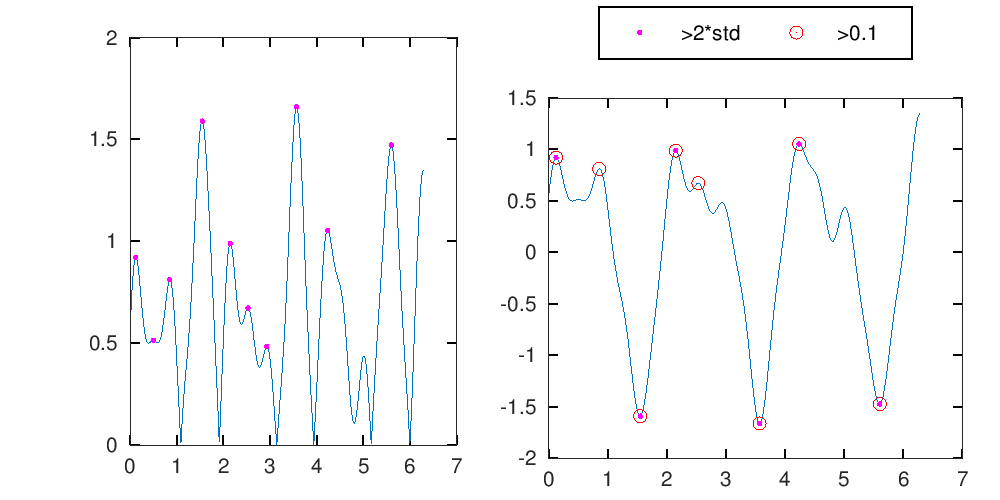

In [11]:
%%octave -s 1000,500 -f png -i t -o idx,pks,data1
pkg load signal
#t = 2*pi*linspace(0,1,1024);
y = sin(3.14*t) + 0.5*cos(6.09*t) + 0.1*sin(10.11*t+1/6) + 0.1*sin(15.3*t+1/3);

data1 = abs(y)'; # Positive values
[pks idx] = findpeaks(data1);

data2 = y; # Double-sided
[pks2 idx2] = findpeaks(data2,"DoubleSided");
[pks3 idx3] = findpeaks(data2,"DoubleSided","MinPeakHeight",0.5);

subplot(1,2,1)
plot(t,data1,t(idx),data1(idx),'.m')
subplot(1,2,2)
plot(t,data2,t(idx2),data2(idx2),".m;>2*std;",t(idx3),data2(idx3),"or;>0.1;")
legend("Location","NorthOutside","Orientation","horizontal")

By default arrays are returned from Octave to Python as floats.  In the case of **idx**, we require ints.

In [12]:
idx = idx.astype(int)

Now do the first plot with Python using the data generated by the Octave block.

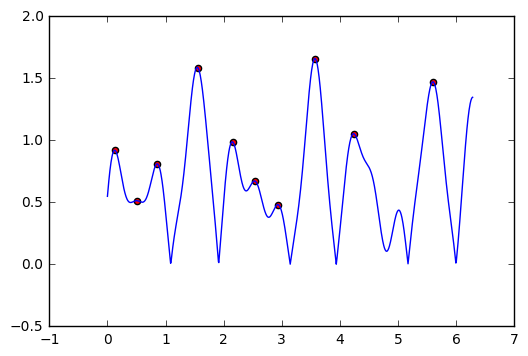

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(t[idx], data1[idx], c='r')
plt.plot(t, data1);

## Plots
Plots generated by Octave can be written back to the notebook in PNG or SVG format.  The output
may look slightly different.

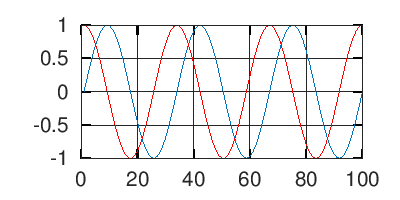

In [14]:
%%octave -f png -s 400,200
t = linspace(0, 6*pi, 100);
plot(sin(t))
grid on
hold on
plot(cos(t), 'r')

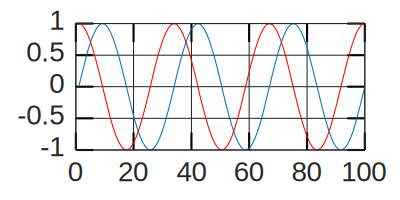

In [15]:
%%octave -f svg -s 400,200
t = linspace(0, 6*pi, 100);
plot(sin(t))
grid on
hold on
plot(cos(t), 'r')

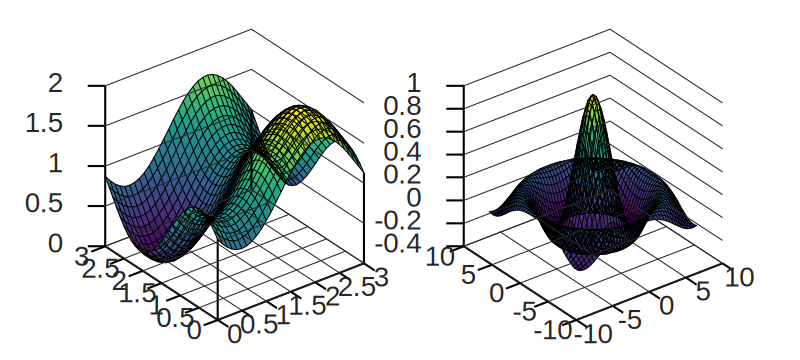

In [16]:
%%octave -s 800,360 -f svg

subplot(121);
[x, y] = meshgrid(0:0.1:3);
r = sin(x - 0.5).^2 + cos(y - 0.5).^2;
surf(x, y, r);

subplot(122);
sombrero()

## Calling Octave Functions

Calling octave functions is very simple.  If they are not in the current directory, you will have to add the directory to the path.

In [17]:
# This would FAIL
#area = %octave triarea(10,10);
#print("The area of the triangle is", area)

In [18]:
# Our funcions are in a subfolder
!ls ofuncs/*.m

ofuncs/ave.m  ofuncs/test_datatypes.m  ofuncs/triarea.m


In [19]:
oct2py.octave.addpath('ofuncs')
area = %octave triarea(10,10);
print("The area of the triangle is", area)

The area of the triangle is 50.0


In [20]:
vec = [1,2,3,4,5]
%octave -i vec ave(vec);

3.0

In [21]:
vec = np.array([1,2,3,4,5])* 10
%octave -i vec ave(vec);

30.0

In [22]:
!cat ofuncs/ave.m

function y = ave(x)
if ~isvector(x)
    error('Input must be a vector')
end
y = sum(x)/length(x);
end
